## Environment Set-up
edit from [sam colab](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=MTeAdX_mHwAR)



If you're running this notebook locally using Jupyter, please clone `SAM-Med2D` into a directory named `SAM_Med2D`. Note that you do **not** need to install `segment_anything` in your local environment, as `SAM-Med2D` and `SAM` share function names that could lead to conflicts.

For Google Colab users: Set `using_colab=True` in the cell below before executing it. Although you can select 'GPU' under 'Edit' -> 'Notebook Settings' -> 'Hardware Accelerator', this notebook is designed to run efficiently in a CPU environment as well.



# SAM-Med2D generates predicted object masks based on prompts.

In [19]:
import glob
import math
import os
import sys
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import torch
import torch.nn.functional as F
from skimage import measure, morphology
from torchvision.transforms.functional import InterpolationMode, rotate
from tqdm import tqdm

In [20]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.array([0, 1, 0, 0.5])
    else:
        color = np.array([1, 0, 0, 0.5])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker=".",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker=".",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

In [21]:
def visualize(slce, predict_mask, gt, points, labels, fn):
    plt.figure(figsize=(5, 5))
    plt.imshow(slce, cmap="gray")
    show_mask(gt, plt.gca(), random_color=True)
    show_mask(predict_mask, plt.gca())
    show_points(points, labels, plt.gca())
    plt.axis("off")
    # plt.show()
    plt.savefig(f"output/{fn}")

In [22]:
def visualize(slce, predict_mask, gt, box, fn):
    plt.figure(figsize=(5, 5))
    plt.imshow(slce, cmap="gray")
    # show_mask(gt, plt.gca(), random_color=True)
    # show_mask(predict_mask, plt.gca())
    # show_box(box, plt.gca())
    gt2 = np.array(gt)
    gt2 = morphology.dilation(gt2, morphology.square(4))
    gt2 = gt2 - gt
    show_mask(gt2, plt.gca(), random_color=True)

    predict_mask2 = np.array(predict_mask)
    predict_mask2 = morphology.dilation(predict_mask2, morphology.square(4))
    predict_mask2 = predict_mask2.astype(float) - predict_mask
    show_mask(predict_mask2, plt.gca())

    plt.axis("off")
    # plt.show()
    plt.savefig(f"output/{fn}")

## Example image

In [23]:
import hydra
from cutie.inference.inference_core import InferenceCore
from cutie.inference.utils.args_utils import get_dataset_cfg
from cutie.model.cutie import CUTIE
from gui.interactive_utils import (
    image_to_torch,
    index_numpy_to_one_hot_torch,
    overlay_davis,
    torch_prob_to_numpy_mask,
)
from hydra import compose, initialize
from omegaconf import open_dict

hydra.core.global_hydra.GlobalHydra.instance().clear()

with torch.inference_mode():
    initialize(
        version_base="1.3.2", config_path="Cutie/cutie/config", job_name="eval_config"
    )
    cfg = compose(config_name="eval_config")

    with open_dict(cfg):
        cfg["weights"] = (
            "/volume/willy-dev/sota/SAM-Med2D/Cutie/weights/cutie-base-mega.pth"
        )

    data_cfg = get_dataset_cfg(cfg)

    # Load the network weights
    cutie = CUTIE(cfg).cuda().eval()
    model_weights = torch.load(cfg.weights)
    cutie.load_weights(model_weights)

processor = InferenceCore(cutie, cfg=cfg)

In [24]:
def norm_slce(slce):
    if torch.is_tensor(slce):
        slce = slce.cpu().numpy()
    slce -= slce.min()
    slce /= slce.max()
    slce *= 255
    slce = slce.astype(np.uint8)
    slce = np.stack([slce, slce, slce], axis=2)
    return slce


def remain_main_areas(mask):

    size_ = max([i.area for i in measure.regionprops(measure.label(mask).astype(int))])
    mask = morphology.remove_small_objects(mask.astype(bool), min_size=size_ - 1)

    return mask


def pad_box(box, pad):
    h, w = box[3] - box[1], box[2] - box[0]
    y, x = (box[3] + box[1]) / 2, (box[2] + box[0]) / 2
    box = np.array([y - h / 2 * pad, x - w / 2 * pad, y + h / 2 * pad, x + w / 2 * pad])
    return box


def get_side_pred(pred, img, gt, rot_point, offset, i):

    gt[gt != (i + 1)] = 0
    gt[gt == (i + 1)] = 1

    slce = norm_slce(img[:, int(rot_point[1])])
    gt_slce = gt[:, int(rot_point[1])].clone()

    frame_torch = image_to_torch(
        slce, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )
    frame_torch = F.interpolate(frame_torch.unsqueeze(0), (480, 480))[0]

    mask_torch = F.interpolate(gt_slce.unsqueeze(0).unsqueeze(0), (480, 480))[0][0]
    if offset == 0:

        init_mask_torch = torch.zeros(4, 480, 480).cuda()
        init_mask_torch[0] = mask_torch

        with torch.inference_mode():
            processor.clear_memory()
            mask, _ = processor.step(frame_torch, init_mask_torch, idx_mask=False)

    else:
        with torch.inference_mode():
            mask, _ = processor.step(frame_torch)

    mask = F.interpolate(mask.unsqueeze(0), (gt_slce.shape[0], gt_slce.shape[1]))[0]
    mask = torch_prob_to_numpy_mask(mask)

    # visualize(slce, mask, gt_slce.cpu().numpy(), [], f"{offset}.png")

    if mask.sum() == 0:
        return pred

    # mask = remain_main_areas(mask)

    z = int(rot_point[1])
    pred[:, [z - 1, z, z + 1]] = (
        torch.tensor(mask).float().unsqueeze(1).repeat(1, 3, 1).cuda()
    )

    return pred


def rotate_(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [25]:
dices = []
dicesb = []
dicesc = []
mms = []
mmms = []

In [26]:
# def rotate_predict(rot_dict, offset, degree):

#     img = rotate(rot_dict["img"], offset, interpolation=InterpolationMode.BILINEAR)
#     mask = rotate(rot_dict["mask"], offset)
#     point = rotate_(
#         [rot_dict["img"].shape[1] // 2, rot_dict["img"].shape[2] // 2],
#         rot_dict["point"],
#         -offset * 0.0174533,
#     )
#     if offset != 0:
#         rot_dict["pred"] = rotate(rot_dict["pred"], degree)

#     rot_dict["pred"] = get_side_pred(
#         rot_dict["pred"],
#         img,
#         mask,
#         point,
#         offset,
#         rot_dict["prop_index"],
#     )
#     offset += degree

#     return rot_dict, offset


# def reset_rotate(rot_dict):
#     rot_dict["pred"] = rotate(rot_dict["pred"], -offset)
#     return rot_dict

In [27]:
def rotate_predict(rot_dict, offset, degree):

    if offset != 0:
        rot_dict["img"] = rotate(
            rot_dict["img"], degree, interpolation=InterpolationMode.BILINEAR
        )
        rot_dict["pred"] = rotate(rot_dict["pred"], degree)
        rot_dict["mask"] = rotate(rot_dict["mask"], degree)
        rot_dict["point"] = rotate_(
            [rot_dict["img"].shape[1] // 2, rot_dict["img"].shape[2] // 2],
            rot_dict["point"],
            -degree * 0.0174533,
        )

    rot_dict["pred"] = get_side_pred(
        rot_dict["pred"],
        rot_dict["img"],
        rot_dict["mask"],
        rot_dict["point"],
        offset,
        rot_dict["prop_index"],
    )
    offset += degree

    return rot_dict, offset


def reset_rotate(rot_dict):
    rot_dict["point"] = centroid[[2, 1]].astype(float)
    rot_dict["img"] = rotate(
        rot_dict["img"], -offset, interpolation=InterpolationMode.BILINEAR
    )
    rot_dict["pred"] = rotate(rot_dict["pred"], -offset)
    rot_dict["mask"] = rotate(rot_dict["mask"], -offset)

    return rot_dict


def norm_volume(img):
    img = img.astype(float)
    img -= img.min()
    img /= img.max()
    img *= 255
    img = img.astype(int)
    return img

In [29]:
dis = glob.glob("/volume/open-dataset-ssd/ai99/gen_data/meningioma/*")

In [47]:
fnss = os.listdir("/volume/open-dataset-nas/AMOS/amos22/imagesTr")
import torch.nn.functional as F

In [78]:
tps = []
fns = []
fps = []
z_dices = []
zs = []

with torch.inference_mode():

    for di in tqdm(dis):

        try:
            nii_img = sitk.ReadImage(f"{di}/axc.nii.gz")
            nii_img = sitk.GetArrayFromImage(nii_img)

            nii_mask = sitk.ReadImage(f"{di}/seg.nii.gz")
            nii_mask = sitk.GetArrayFromImage(nii_mask)
        except:
            continue

        nii_mask = measure.label(nii_mask)
        nii_img = norm_volume(nii_img)

        img = np.array(nii_img)
        mask = np.array(nii_mask)

        for i, prop in enumerate(measure.regionprops(mask)):

            if prop.area == 0:
                continue

            centroid = np.array(prop.centroid)
            tensor_img = torch.tensor(img.astype(float)).cuda()
            tensor_mask = torch.tensor(mask.astype(float)).cuda()

            max_length = 512

            tensor_img = F.interpolate(
                tensor_img.unsqueeze(0).unsqueeze(0),
                [max_length, max_length, max_length],
            )[0][0]
            tensor_mask = F.interpolate(
                tensor_mask.unsqueeze(0).unsqueeze(0),
                [max_length, max_length, max_length],
            )[0][0]

            centroid = centroid * np.array(
                [
                    max_length / img.shape[0],
                    max_length / img.shape[1],
                    max_length / img.shape[2],
                ]
            )

            tensor_img = tensor_img.permute(1, 0, 2).contiguous()
            tensor_mask = tensor_mask.permute(1, 0, 2).contiguous()
            centroid = centroid[[1, 0, 2]]

            rot_dict = {
                "img": tensor_img,
                "mask": tensor_mask,
                "point": centroid[[2, 1]],
                "prop_index": i,
                "prop": prop,
            }
            rot_dict["pred"] = torch.zeros_like(rot_dict["img"]).float().cuda()

            zx_ratio = max(img.shape[1], img.shape[2]) / img.shape[0]

            degree_ = 2
            if 10 > zx_ratio >= 6:
                degree_ = 3
            if 6 > zx_ratio:
                degree_ = 5

            degree, offset = degree_, 0
            while offset <= 90:
                rot_dict, offset = rotate_predict(rot_dict, offset, degree)
            rot_dict = reset_rotate(rot_dict)

            # degree, offset = -degree_, 0
            # while offset >= -90:
            #     rot_dict, offset = rotate_predict(rot_dict, offset, degree)
            # rot_dict = reset_rotate(rot_dict)

            rot_dict["pred"] = rot_dict["pred"].permute(1, 0, 2).contiguous()
            # tensor_img = tensor_img.permute(1, 0, 2).contiguous()
            # tensor_mask = tensor_mask.permute(1, 0, 2).contiguous()
            # centroid = centroid[[1, 0, 2]]

            rot_dict["pred"] = F.interpolate(
                rot_dict["pred"].unsqueeze(0).unsqueeze(0), img.shape, mode="trilinear"
            )[0][0]

            z_pred = (rot_dict["pred"].sum((1, 2)) > 0).int()
            z_gt = torch.tensor(mask.sum((1, 2))).cuda()
            z_gt = (z_gt > 0).int()

            tp = (z_pred * z_gt).sum()
            fp = ((z_gt == 0) * z_pred).sum()
            fn = ((z_pred == 0) * z_gt).sum()

            z_dice = 2 * tp / (2 * tp + fp + fn)
            z_dices.append(z_dice.cpu().numpy())
            tps.append(tp.cpu().numpy())
            fps.append(fp.cpu().numpy())
            fns.append(fn.cpu().numpy())
            zs.append(img.shape[0])

            print(z_dice)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 910/910 [03:28<00:00,  4.36it/s]


In [32]:
np.save("z_dices.npy", z_dices)
np.save("tps.npy", tps)
np.save("fps.npy", fps)
np.save("fns.npy", fns)
np.save("zs.npy", zs)

In [ ]:
# tensor_img = F.interpolate(tensor_img.unsqueeze(0).unsqueeze(0), resample_size_512.tolist())[0][0]
# tensor_mask = F.interpolate(tensor_mask.unsqueeze(0).unsqueeze(0), resample_size_512.tolist())[0][0]
# rot_dict["pred"] = F.interpolate(rot_dict["pred"].unsqueeze(0).unsqueeze(0), resample_size_512.tolist())[0][0]

In [ ]:
# centroid = centroid * np.array(
#             [
#                 resample_size_512[0] / 512,
#                 resample_size_512[1] / 512,
#                 resample_size_512[2] / 512,
#             ]
#         )

In [ ]:
# pad_z1 = (512 - resample_size_512[0]) // 2
# pad_z2 = 512 - pad_z1 - resample_size_512[0]

In [ ]:
# tensor_img = F.pad(tensor_img, (0, 0, 0, 0, pad_z1, pad_z2), "constant", 0)
# tensor_mask = F.pad(tensor_mask, (0, 0, 0, 0, pad_z1, pad_z2), "constant", 0)
# rot_dict["pred"] = F.pad(rot_dict["pred"], (0, 0, 0, 0, pad_z1, pad_z2), "constant", 0)
# centroid[0] += pad_z1

In [ ]:
# tensor_img2 = tensor_img.permute(1, 0, 2).contiguous()
# tensor_mask2 = tensor_mask.permute(1, 0, 2).contiguous()
# rot_dict2 = rot_dict["pred"].permute(1, 0, 2).contiguous()
# centroid2 = centroid[[1, 0, 2]]

# for deg in range(120):
#     img2 = rotate(tensor_img2, deg * 3, interpolation=InterpolationMode.BILINEAR)
#     mask2 = rotate(tensor_mask2, deg * 3)
#     pred2 = rotate(rot_dict2, deg * 3)
#     point2 = rotate_(
#         [tensor_img.shape[1] // 2, tensor_img.shape[2] // 2],
#         centroid2[[2, 1]],
#         -deg * 3 * 0.0174533,
#     )
#     visualize(
#         img2[:, int(point2[1])].cpu().numpy(),
#         morphology.convex_hull_image(pred2[:, int(point2[1])].cpu().numpy()),
#         mask2[:, int(point2[1])].cpu().numpy(),
#         [],
#         f"{deg}.png",
#     )

(array([ 66.,   1.,   5.,   3.,   1.,   4.,   5.,   9.,  12.,   8.,  14.,
         12.,  12.,  31.,  25.,  35.,  79.,  92., 174., 260.]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

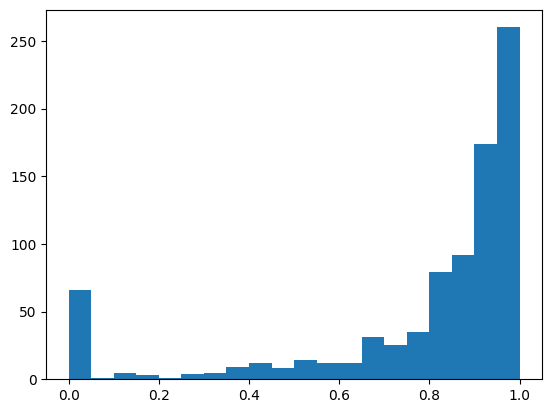

In [67]:
plt.hist(z_dices, bins=20)

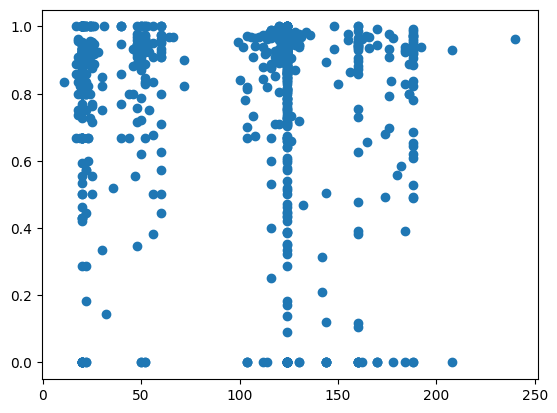

In [68]:
plt.scatter(
    zs,
    z_dices,
)

In [70]:
np.mean(z_dices), np.sum(tps) / (np.sum(tps) + np.sum(fns)), np.sum(tps) / (
    np.sum(tps) + np.sum(fps)
)

(0.7843222, 0.7962923274753536, 0.7928937259923176)